# Biased VAMP Workflow for Alanine Dipeptide

This notebook showcases the new `BiasedVAMPWorkflow`, which augments the standard VAMP pipeline with support for biased molecular dynamics trajectories. We reproduce the alanine-dipeptide example from [L. Bonati *et al.*](https://github.com/luigibonati/md-stateinterpreter/blob/main/tutorials/1_compute_deepTICA.ipynb) using the publicly available biased PLUMED outputs.

In [1]:
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from geom2vec import create_model_from_checkpoint
from geom2vec.data import infer_mdanalysis_folder
from geom2vec.models.downstream import Lobe

from geom2vec.models.downstream.vamp.workflow import BiasedVAMPWorkflow
from geom2vec.models.downstream.vamp.vampnet import VAMPNetConfig

plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['axes.grid'] = False


/project/dinner/zpengmei/conda_envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/pyg/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/project/dinner/zpengmei/conda_envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/pyg/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
DATA_DIR = Path("geom2vec_02/examples/_artifacts/alanine_bias")
DATA_DIR.mkdir(parents=True, exist_ok=True)

REMOTE_FILES = {
    "COLVAR": "https://raw.githubusercontent.com/luigibonati/md-stateinterpreter/main/tutorials/alanine/COLVAR",
    "alanine.xtc": "https://raw.githubusercontent.com/luigibonati/md-stateinterpreter/main/tutorials/alanine/alanine.xtc",
    "input.ala2.pdb": "https://raw.githubusercontent.com/luigibonati/md-stateinterpreter/main/tutorials/alanine/input.ala2.pdb",
}

for name, url in REMOTE_FILES.items():
    target = DATA_DIR / name
    if target.exists():
        print(f"Found existing {name}")
        continue
    print(f"Downloading {name} ...", end=" ")
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(target, "wb") as fh:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    fh.write(chunk)
    print("done")

xtc_path = DATA_DIR / "alanine.xtc"
pdb_path = DATA_DIR / "input.ala2.pdb"


Found existing COLVAR
Found existing alanine.xtc
Found existing input.ala2.pdb


In [3]:
colvar_path = DATA_DIR / "COLVAR"
# Extract header from PLUMED comment line
with open(colvar_path, 'r') as handle:
    header_fields = None
    for line in handle:
        if line.startswith('#! FIELDS'):
            parts = line.strip().split()
            header_fields = parts[2:]
            break
    if header_fields is None:
        raise ValueError('Could not locate #! FIELDS line in COLVAR file.')

df = pd.read_csv(
    colvar_path,
    comment='#',
    sep='\s+',
    header=None,
    names=header_fields,
)

stride = 5  # keep stride consistent across embeddings and reweighting
df = df.iloc[::stride].reset_index(drop=True)

bias_cols = [col for col in df.columns if col.endswith('.bias')]
bias_total = df[bias_cols].sum(axis=1).to_numpy(dtype=np.float32)

k_b = 0.008314  # kJ mol^-1 K^-1
temperature = 300.0  # Kelvin
beta = 1.0 / (k_b * temperature)
log_weights = beta * bias_total

phi = df['phi'].to_numpy(dtype=np.float32)
psi = df['psi'].to_numpy(dtype=np.float32)

print(f"Frames used after stride {stride}: {len(df):,}")
print(f"Available bias columns: {len(bias_cols)}")


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/scratch/local/jobs/38012634/ipykernel_257649/2908683542.py:16: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


Frames used after stride 5: 10,001
Available bias columns: 1


In [4]:
embedding_dir = DATA_DIR / "embeddings"
embedding_dir.mkdir(parents=True, exist_ok=True)

checkpoint_path = Path("geom2vec_02/geom2vec/checkpoints/visnet_l6_h64_rbf64_r75.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rep_model = create_model_from_checkpoint(
    checkpoint_path=str(checkpoint_path),
    device=device,
)

summary = infer_mdanalysis_folder(
    model=rep_model,
    topology_file=str(pdb_path),
    trajectory_folder=str(DATA_DIR),
    output_dir=str(embedding_dir),
    stride=stride,
    selection="prop mass > 1.5",
    file_postfix=".xtc",
    batch_size=64,
    reduction="sum",
    overwrite=False,
)
summary


/project/dinner/zpengmei/geom2vec_02/geom2vec/src/geom2vec/models/factory.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

Model loaded from geom2vec_02/geom2vec/checkpoints/visnet_l6_h64_rbf64_r75.pth


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

{'computed': [],
 'skipped': [PosixPath('geom2vec_02/examples/_artifacts/alanine_bias/embeddings/alanine.pt')]}

In [5]:
embedding_paths = sorted((embedding_dir).glob('*.pt'))
if not embedding_paths:
    raise FileNotFoundError('Run the inference cell above to generate geom2vec embeddings.')

trajectories = [torch.load(path, map_location='cpu').float() for path in embedding_paths]
print('Embeddings:', [tuple(t.shape) for t in trajectories])

import MDAnalysis as mda

ca_cache = embedding_dir / 'alanine_residue_coords.pt'
def compute_residue_coords():
    universe = mda.Universe(str(pdb_path), str(xtc_path))
    selected = universe.select_atoms('prop mass > 1.5')
    residues = selected.residues
    coords = []
    for ts in universe.trajectory[::stride]:
        coords.append([res.atoms.center_of_geometry() for res in residues])
    return torch.tensor(np.asarray(coords), dtype=torch.float32)

if ca_cache.exists():
    ca_coords = torch.load(ca_cache).float()
else:
    ca_coords = compute_residue_coords()
    torch.save(ca_coords, ca_cache)

embedding = trajectories[0]
if ca_coords.shape[1] != embedding.shape[1] or ca_coords.shape[0] != embedding.shape[0]:
    ca_coords = compute_residue_coords()
    torch.save(ca_coords, ca_cache)

print('Residue coordinate shape:', tuple(ca_coords.shape))

num_frames = min(embedding.shape[0], ca_coords.shape[0], len(log_weights), len(phi), len(psi))
embedding = embedding[:num_frames]
ca_coords = ca_coords[:num_frames]
log_weights = log_weights[:num_frames]
phi = phi[:num_frames]
psi = psi[:num_frames]
if len(trajectories) > 1:
    trajectories = [traj[:num_frames] for traj in trajectories]
else:
    trajectories = [embedding]

trajectory_entries = [{"graph_features": trajectories[0], "ca_coords": ca_coords}]
print(f'Aligned frames: {num_frames}, tokens: {embedding.shape[1]}, hidden dim: {embedding.shape[-1]}')


Embeddings: [(10001, 3, 4, 64), (10001, 3, 3)]
Residue coordinate shape: (10001, 3, 3)
Aligned frames: 10001, tokens: 3, hidden dim: 64


/scratch/local/jobs/38012634/ipykernel_257649/1585229515.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trajectories = [torch.load(path, map_location='cpu').float() for

In [6]:
hidden_channels = trajectories[0].shape[-1]
num_tokens = trajectories[0].shape[1]
merger_enabled = num_tokens >= 4

lobe = Lobe(
    hidden_channels=hidden_channels,
    output_channels=2,
    num_mlp_layers=3,
    num_tokens=num_tokens,
    merger=merger_enabled,
    merger_window=2,
)

config = VAMPNetConfig(
    device='cpu',
    learning_rate=1e-4,
    train_patience=25,
    valid_patience=25,
    train_valid_interval=200,
    score_method='vamp-2',
)

weights_array = np.asarray(log_weights, dtype=np.float32)

workflow = BiasedVAMPWorkflow(
    lobe=lobe,
    trajectories=trajectory_entries,
    lag_time=1,
    log_weights=[weights_array],
    batch_size=1024,
    train_fraction=0.8,
    dtype=torch.float32,
    seed=42,
    config=config,
    shuffle_trajectories=False,
)
workflow


In [7]:
vamp = workflow.fit(n_epochs=150)


best val: -inf: 0it [00:00, ?it/s]

epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Training patience reached at epoch 19


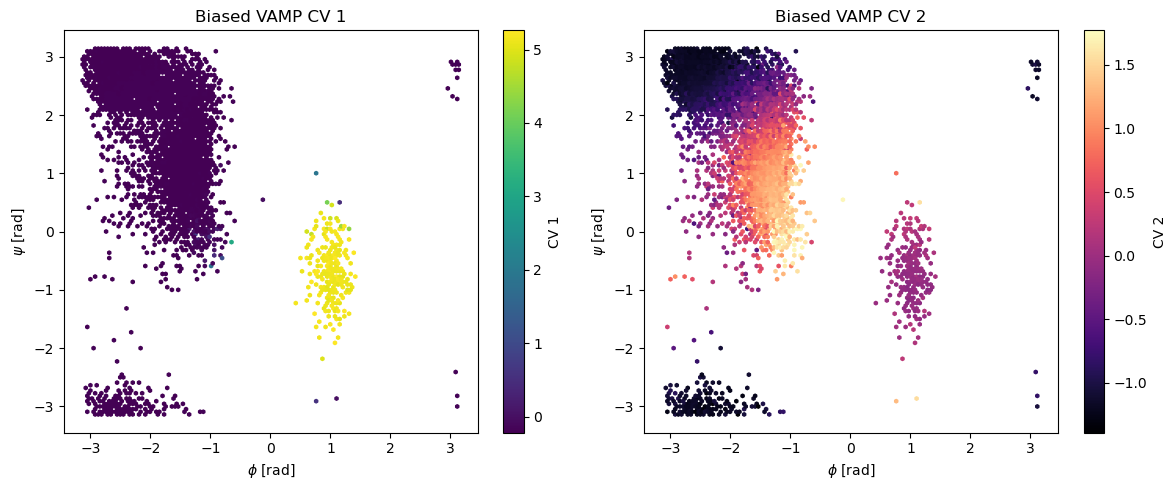

: 

In [ ]:
train_cvs = workflow.get_cvs(split="train", instantaneous=True)
train_cvs = train_cvs
train_cvs = np.asarray(train_cvs)
if train_cvs.ndim == 1:
    train_cvs = train_cvs.reshape(-1, 1)
sample_count = train_cvs.shape[0]
phi_samples = phi[:sample_count]
psi_samples = psi[:sample_count]
num_cvs = train_cvs.shape[1]
fig, axes = plt.subplots(1, num_cvs, figsize=(6 * num_cvs, 5), squeeze=False)
cmaps = ['viridis', 'magma', 'plasma', 'cividis']
axes = axes[0]
for idx in range(num_cvs):
    ax = axes[idx]
    cmap = cmaps[idx % len(cmaps)]
    sc = ax.hexbin(phi_samples, psi_samples, C=train_cvs[:, idx], gridsize=120, cmap=cmap)
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    ax.set_title(f'Biased VAMP CV {idx + 1}')
    fig.colorbar(sc, ax=ax, label=f'CV {idx + 1}')
plt.tight_layout()
plt.show()
